In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
mean = cards_to_age["age"].mean()
if random.random() < (.005+(mean/1000)):
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications
priority_headers = [
    "Django", 
    "Python + Oauth2.0"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.075
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
eDiscovery,654.108758,12.113125,76.390607,54
Ubuntu,315.036334,12.116782,61.974200,26
TSQL,41.565840,13.855280,19.053974,3
Network Terms,230.274792,15.351653,36.709114,15
GUI Docker Container,378.456603,18.021743,47.967050,21
SSH + SCP,546.069937,18.829998,96.095523,29
Exchange Online and Defender,828.789708,21.251018,71.554471,39
"The Mines of the Behemoth, Shea",1181.149549,24.105093,119.095126,49
"Everything is Tuberculosis, Green",665.169240,28.920402,189.778578,23
Power BI,292.531823,36.566478,119.364043,8


# Histogram

sum of ages: ~38357.29


<Axes: >

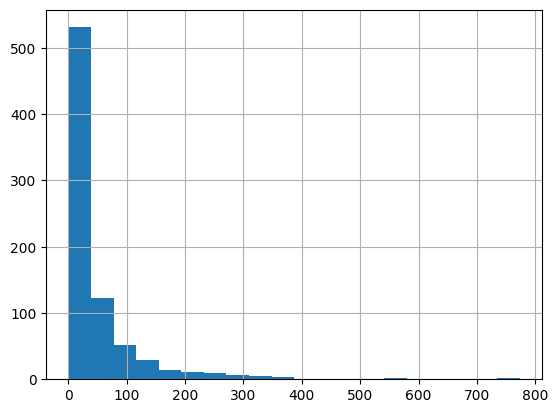

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~38357.29


<Axes: >

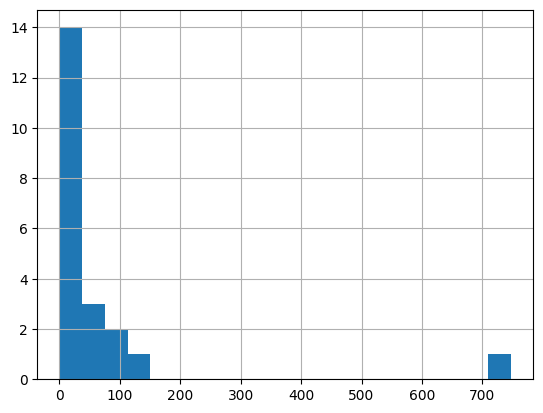

In [16]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='WinHex']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [ ]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [ ]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


Cards found: 790
Total card age: 38357.29


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
109,Microsoft Purview,"The technical metadata includes schema, data t...",e075b6e051b56bf4339683cc14994184,772.932278,91.638609,-772.932278,3665.544363,0.576315,40,0,0,-772.932278
110,Microsoft Purview,The most effective end-user documentation will...,cd14ee472435ecdf15fed24da734eca3,360.032281,91.638609,-772.932278,3665.544363,0.576315,40,1,0,-360.032281
111,Microsoft Purview,You can apply just one sensitivity label to an...,50f85d7bb8f9e04601a53f72976eeb45,303.314001,91.638609,-772.932278,3665.544363,0.576315,40,2,0,-303.314001
112,Microsoft Purview,Microsoft Purview includes:\nSensitive informa...,3c753353c6695bdcff7b2121467b00ed,278.173349,91.638609,-772.932278,3665.544363,0.576315,40,3,0,-278.173349
113,Microsoft Purview,Data understanding is about ensure data has qu...,9a95bac80e7ba590c49d6bcab8edaf38,276.391148,91.638609,-772.932278,3665.544363,0.576315,40,4,0,-276.391148
34,WinHex,Advanced Adjacent Terms\nZoned Bit Recording (...,6c188d655123f654671ddbe9e25ee8b3,746.978820,65.066296,-746.978820,1366.392207,0.630164,21,0,0,-746.978820
35,WinHex,Logical vs Physical Sector Size\n\nLogical sec...,e30362eb2c78ec875801491a73a10181,122.778733,65.066296,-746.978820,1366.392207,0.630164,21,1,0,-122.778733
36,WinHex,Entropy Check\nA method to verify sanitization...,5727c80ef50a24468b394a5b59c20598,100.069218,65.066296,-746.978820,1366.392207,0.630164,21,2,0,-100.069218
37,WinHex,Boot Sector\nFirst sector of a filesystem (NTF...,56070a6f547fdebc1dd222221ace4aaa,79.390436,65.066296,-746.978820,1366.392207,0.630164,21,3,0,-79.390436
38,WinHex,HPA (Host Protected Area) & DCO (Device Config...,4b9ced335c770908c42c93aafb8be5b2,66.610895,65.066296,-746.978820,1366.392207,0.630164,21,4,0,-66.610895


## Card Count

In [11]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(3106.6711599232162)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
109,Microsoft Purview,"The technical metadata includes schema, data t...",e075b6e051b56bf4339683cc14994184,772.932278,91.638609,-772.932278,3665.544363,0.576315,40,0,0,-772.932278
34,WinHex,Advanced Adjacent Terms\nZoned Bit Recording (...,6c188d655123f654671ddbe9e25ee8b3,746.978820,65.066296,-746.978820,1366.392207,0.630164,21,0,0,-746.978820
99,Node.js and Vite,Debugger attached\nA message from Node when ru...,128567e0fcdb7e5c074de0dc7ff33928,606.672899,80.319432,-606.672899,2811.180121,0.289701,35,0,0,-606.672899
100,Node.js and Vite,"""Unexpected token"" (Babel error)\nJS syntax er...",9c8d82516fc972a6c5b042007d3943a8,578.636515,80.319432,-606.672899,2811.180121,0.289701,35,1,0,-578.636515
79,Terraform Codebox,corepack enable\nA command that activates Core...,dbbb73cbfd843df20879274cb633c9ac,567.055786,73.383142,-567.055786,2348.260552,0.430608,32,0,0,-567.055786
44,"Mexican Gothic, Moreno-Garcia","trousseau (troo-SOH)\nnoun\nThe clothes, linen...",e68146db262d468ec9bc38f4439717a0,429.531543,59.680255,-429.531543,1372.645857,0.090580,23,0,0,-429.531543
9,Python + Oauth2.0,handler.wfile.write()\n\nWrites a response bac...,0a49706ef2305810297830c1b5b23dc6,380.203632,112.691045,-380.203632,1803.056718,0.937335,16,0,0,-380.203632
10,Python + Oauth2.0,urllib.parse.urlencode()\n\nEncodes a dictiona...,a6a4fec4f5f3154e2890a09a3ec81636,362.863561,112.691045,-380.203632,1803.056718,0.937335,16,1,0,-362.863561
110,Microsoft Purview,The most effective end-user documentation will...,cd14ee472435ecdf15fed24da734eca3,360.032281,91.638609,-772.932278,3665.544363,0.576315,40,1,0,-360.032281
80,Terraform Codebox,"In Windows PowerShell, RSA SSH keys can be gen...",51fc9593224fc39fc8e432d6be5db48e,350.182128,73.383142,-567.055786,2348.260552,0.430608,32,1,0,-350.182128


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 48.554'